# Reproducibility summary

The original paper introduces a new unsupervised representation learning method called TRACE which builds on the TNC (Temporal Neighborhood Coding) framework to produce better predictions on ICU data. 

The claim we picked from the paper to test is that TRACE will have higher accuracy than baseline models including TNC, CPC, T-Loss, and Supervised with end-to-end encoding on label prediction.

In our attempts to reproduce the paper we were able to prove the claim that TRACE would have a higher accuracy than baseline models in predicting labels, and we were able to do so on a different dataset than what was used in the original paper. This is compelling evidence that the model introduced by the original paper can be used in general for ICU data. 

# Visualization of data statistics

There were many different signals present for each patient in the data. Not all of them were present in every patient, meaning if we used all the features there would be a lot of sparseness in the data. With most of the signals appearing only once in a patient, it made sense to cut out some of them as they only provide noise to the model. 

In the below chart, the y-axis represents the number of patients that the signal was present, and the x-axis represents each signal. 

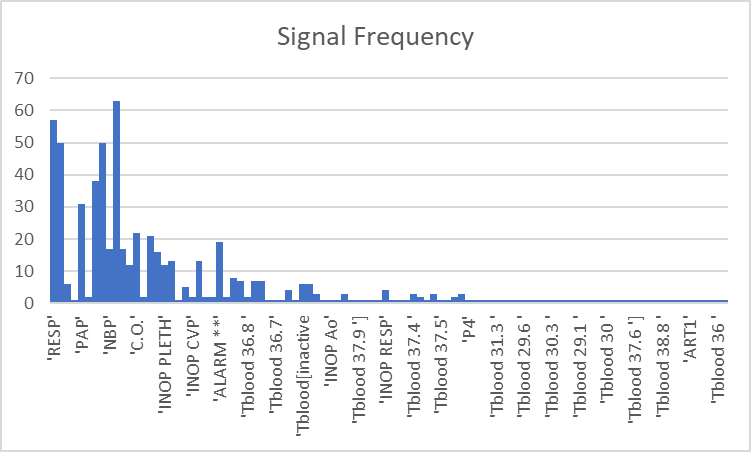

In [1]:
from IPython.display import Image
Image('signal_frequency.png')

# Methodology explanation and examples

We plan to re-implement the models from the paper ourselves while using the authors’ code as reference. These include the aforementioned models TRACE, CPC, T-Loss, and Supervised E2E.

The authors provide a link to a GitHub repository with their code, including some light documentation covering how to create the encoding for the specific data set they used. We will be using the MIMIC dataset Moody and Mark (1996) as we were unable to get access to the HiRID dataset before the project deadline.

Due to this change in our data source, this meant that we were unable to use the data processing used by the original paper. Instead we did a data exploration of the MIMIC dataset and processed it ourselves with our own code implementation from scratch. This was time-consuming and labor-intensive, not to mention that we also had to change parts of the model implementation to account for the data we generated from MIMIC.  

## Label Generation Code

To check our model accuracy, we generated labels based on the ”PULSE” signal having 0 values present for a patient’s time-series data, indicating that they experienced a cardiac arrest event. If the patient had no 0 values present in their time-series data for the ”PULSE” signal, then we know that they did not have a cardiac arrest event. A label of 0 means the patient did not have a cardiac arrest event, and a label of 1 means the patient did.

In [2]:
import os

def get_patient_labels():
    """ loop through patient folders and get label for each one

    Returns:
        dict: dictionary of patients and their labels
    """
    patient_labels = {}
    first_cardiac_arrest_records = {}

    for folder_name in os.listdir(os.path.join(os.getcwd(), "mimic-database-small-version")):
        if folder_name.isdigit():
            print(f"Getting label for patient name: {folder_name}")
            # loop through every file
            had_cardiac_arrest, first_cardiac_arrest_record = get_had_cardiac_arrest(folder_name)
            if had_cardiac_arrest:
                patient_labels[folder_name] = 1
                first_cardiac_arrest_records[folder_name] = first_cardiac_arrest_record
            else:
                patient_labels[folder_name] = 0
    return patient_labels, first_cardiac_arrest_records


def get_had_cardiac_arrest(folder_name):
    """ gets cardiac arrest boolean from files in patient folder

    Args:
        folderName (str): the name of the folder

    Returns:
        boolean: whether the patient had a cardiac arrest event
    """
    file_names = os.listdir(os.path.join(os.getcwd(), "mimic-database-small-version", folder_name))
    pulse_record_ct = 0
    for file_name in file_names:
        # if the file name ends with txt
        if file_name.endswith((".txt")):
            file_path = os.path.join(os.getcwd(), "mimic-database-small-version", folder_name, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                for line in lines:
                    if line.startswith(("PULSE")):
                        pulse_record_ct += 1
                        reading = line.split("\t")
                        if len(reading) >= 2:
                            pulse = int(reading[1])
                            if pulse == 0:
                                return True, pulse_record_ct
    return False, None

def write_labels_to_file(patient_labels, first_cardiac_arrest_records):
      for patient, label in patient_labels.items():
          print(f"Patient {patient} has label: {label}")

In [3]:
patient_labels, first_cardiac_arrest_records = get_patient_labels()
write_labels_to_file(patient_labels, first_cardiac_arrest_records)

Getting label for patient name: 211
Getting label for patient name: 041
Getting label for patient name: 037
Getting label for patient name: 039
Patient 211 has label: 0
Patient 041 has label: 1
Patient 037 has label: 1
Patient 039 has label: 1


This is different from the original paper as in the original paper they try to predict cardiopulmonary arrest and mortality labels. Cardiopulmonary arrest is the cessation of breathing and circulation. This would have been more difficult to generate labels for due to the low number of quality signal types and the lack of a clear definition of mortality in relation to those signals. By quality, we refer to the low number of common signals between patients. 

Therefore it made sense to use only one of our quality signals to generate labels instead of two, as we are only interested in how TRACE performs in comparison to baseline models, rather than on the labels themselves. 

## Data Generation Code

We also had to generate usable data from the raw data files from MIMIC. In order to do this we looped through each patient folder's files line by line, and extracted all the features that we wanted to use for our model.

In [4]:
import os

def write_patient_data():
    """ loop through patient folders and get label for each one

    Returns:
        dict: dictionary of patients and their labels
    """
    patient_labels = {}
    valid_patients = ['211', '471', '476', '449', '041', '413', '414', '221', '226', '415', '401', '408', '260', '409', '055', '037', '039', '248', '417', '212', '472', '240', '418', '427', '474', '442', '213', '231', '253', '254', '291', '237', '230', '466', '403', '252']
   
    valid_patients_labels = dict()
    first_cardiac_arrest_records = dict()
    
    with open('mimic-database-small-version/labels.csv', 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            patient_id, label = line.split(",")
            label = int(label)
            
            if patient_id in valid_patients:
                valid_patients_labels[patient_id] = label
    
    with open('mimic-database-small-version/first_cardiac_arrest_record.csv', 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            patient_id, index = line.split(",")
            index = int(index)
            
            if patient_id in valid_patients:
                first_cardiac_arrest_records[patient_id] = index
    

    for folder_name in os.listdir(os.path.join(os.getcwd(), "mimic-database-small-version")):
        if folder_name.isdigit() and folder_name in valid_patients:
            print(f"Getting data for patient name: {folder_name}")
            # loop through every file
            patient_data = get_data_per_patient(folder_name)
            write_data_to_file(folder_name, patient_data, valid_patients_labels, first_cardiac_arrest_records)
            
            
    return patient_labels

def get_data_per_patient(folder_name):
    """Gets data for each patient in terms of columns

    Args:
        folder_name (str): patient name
    Returns:
        dict<str, list>: dictionary signal names as keys and a list of values for each signal in order
    """
    patient_data = {}
    file_names = os.listdir(os.path.join(os.getcwd(), "mimic-database-small-version", folder_name))
    for file_name in file_names:
        # if the file name ends with txt
        if file_name.endswith((".txt")):
            file_path = os.path.join(os.getcwd(), "mimic-database-small-version", folder_name, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                for line in lines:
                    if line.startswith(("SpO2")) or line.startswith(("RESP")) or line.startswith(("HR")) or line.startswith(("ABP")):
                        reading = line.split("\t")
                        if len(reading) == 2:
                            signal = reading[0].strip()
                            value = int(float(reading[1]))
                            #print(f"Signal: {signal}, Value: {value}")
                            if signal != "ABP":
                                if signal not in patient_data:
                                    patient_data[signal] = [value]
                                else:
                                    patient_data[signal].append(value)
                            else:
                                if "ABP1" not in patient_data and "ABP2" not in patient_data and "ABP3" not in patient_data:
                                    patient_data["ABP1"] = [value]
                                    patient_data["ABP2"] = [value]
                                    patient_data["ABP3"] = [value]
                                else:
                                    patient_data["ABP1"].append(value)
                                    patient_data["ABP2"].append(value)
                                    patient_data["ABP3"].append(value)
                        elif len(reading) > 2:
                            values = reading[1:]
                            for index, value in enumerate(values):
                                currentABP = f"ABP{index+1}"
                                #print(f"Signal: {currentABP}, Value: {value}")
                                if currentABP not in patient_data:
                                    patient_data[currentABP] = [int(value)]
                                else:
                                    patient_data[currentABP].append(int(value))
    return patient_data

def write_data_to_file(patient_id, patient_data, valid_patients_labels, first_cardiac_arrest_records):
    # find which patients are positive and negative
    NUM_RECORDS = 10000

    with open(f'mimic-database-small-version/valid_patient_data/{patient_id}_data.csv', 'w', encoding='utf-8') as f:
        temp_record = {}
        record_number = None
        if valid_patients_labels[patient_id] == 0:
            record_number = NUM_RECORDS
        else:
            record_number = max(NUM_RECORDS, first_cardiac_arrest_records[patient_id])
        
        signal_list = ["SpO2", "RESP", "HR", "ABP1", "ABP2", "ABP3"]
        print("record_id,SpO2,RESP,HR,ABP1,ABP2,ABP3")

        for record_id in range(record_number-NUM_RECORDS,  record_number):
            for signal in signal_list:
                temp_record[signal] = patient_data[signal][record_id]
            if record_id % 1000 == 0:
                print("{},{},{},{},{},{},{}".format(record_id+1, temp_record["SpO2"], temp_record["RESP"], temp_record["HR"], temp_record["ABP1"], temp_record["ABP2"], temp_record["ABP3"]))

In [5]:
write_patient_data()

Getting data for patient name: 211
record_id,SpO2,RESP,HR,ABP1,ABP2,ABP3
1,95,8,90,76,137,50
1001,92,2,88,104,191,62
2001,0,14,93,98,157,62
3001,0,11,96,129,209,76
4001,0,29,94,102,163,65
5001,93,5,90,117,204,69
6001,0,11,95,132,223,72
7001,93,0,87,83,153,53
8001,0,11,97,121,196,72
9001,0,0,91,84,142,53
Getting data for patient name: 041
record_id,SpO2,RESP,HR,ABP1,ABP2,ABP3
1,93,14,82,92,135,73
1001,93,14,81,85,129,68
2001,91,14,89,56,88,42
3001,94,14,87,75,114,56
4001,97,14,76,92,138,73
5001,82,16,102,86,118,67
6001,97,14,81,87,133,69
7001,96,14,82,87,132,70
8001,97,14,86,81,117,64
9001,93,14,72,83,122,68
Getting data for patient name: 037
record_id,SpO2,RESP,HR,ABP1,ABP2,ABP3
1,0,18,117,69,87,59
1001,0,18,117,77,96,68
2001,0,18,121,50,68,42
3001,0,18,123,33,44,28
4001,0,18,125,53,70,45
5001,0,18,116,77,96,68
6001,0,31,122,78,99,67
7001,0,18,115,69,86,60
8001,0,18,124,48,65,39
9001,0,18,158,52,67,44
Getting data for patient name: 039
record_id,SpO2,RESP,HR,ABP1,ABP2,ABP3
1,92,14,105,

{}

## TRACE Overview

The TRACE method is a simplified contrastive learning objective to train the model. The goal of contrastive learning is to learn a representation of input data that captures the underlying structure of the data by contrasting pairs of similar and dissimilar examples. The representation maps similar data points closer together in the representation space and maps dissimilar data points further apart. The objective in the context of our data is to label which patients experienced a cardiac arrest event over time series data. The objective in general is fluid, and labels can be created for any particular event related to the data.  

The model consists of two neural networks, the encoder and the discriminator. The encoder is a dilated causal convolutional neural network with 4 layers; MaxPool1d, Squeeze, Linear, and Sequential layers. The discriminator is a simple single layer Multi-Layer Perceptron. The encoder and the discriminator both have 7 defined parameters. 

in-channels = 6; this represents the 6 physiological signals which we use to make predictions based on: SpO2, Respiratory Rate, Heart Rate, and 3 types of ABP measures.

channels = 4; this represents the number of channels manipulated by our encoder.

depth = 1; the depth of the input layer is only 1 because they are simple numeric data.

reduced-size = 2; this is the length to which the output time series of the encoder is reduced.

encoding-size = 10; this is the number of output channels for our encoder.

kernel-size = 2; this is the kernel size for our encoder which is a CNN.

window-size = 12; this represents the amount of data to encode at a time, in this case, we encode 12 entries at a time.

The encoder has additional features, including filters that are exponentially dilated meaning deeper layers have filters that have been stretched out, leading to a larger receptive field, while making sure the output at time t is only reliant on time series data up to time t. When generating an encoding for a window Wt, the encoder is also fed the missing data mask to incorporate that information into its learning.

### Initializing Parameters and Importing Dependencies

In [6]:
import torch

from cpc import cpc
from end_to_end import end_to_end
from trace_model import trace
from triplet_loss import triplet_loss

# Interval between recordings
interval = 1

# Setting hyperparams
encoder_type = "CausalCNNEncoder"

# Learn encoder hyperparams
window_size = 60
w = 0.05
batch_size = 30
lr = .00005
decay = 0.0005
mc_sample_size = 6
n_epochs = 150
data_type = "mimic"
n_cross_val_encoder = 1
ETA = 4
ADF = False
ACF = False
ACF_PLUS = True
ACF_nghd_Threshold = 0.6
ACF_out_nghd_Threshold = 0.1

# CausalCNNEncoder Hyperparameters
CausalCNNEncoder_in_channels = 6
CausalCNNEncoder_channels = 4
CausalCNNEncoder_depth = 1
CausalCNNEncoder_reduced_size = 2
CausalCNNEncoder_encoding_size = 10
CausalCNNEncoder_kernel_size = 2
CausalCNNEncoder_window_size = 12

n_cross_val_classification = 3

encoder_hyper_params = {'in_channels': CausalCNNEncoder_in_channels,
                            'channels': CausalCNNEncoder_channels, 
                            'depth': CausalCNNEncoder_depth, 
                            'reduced_size': CausalCNNEncoder_reduced_size,
                            'encoding_size': CausalCNNEncoder_encoding_size,
                            'kernel_size': CausalCNNEncoder_kernel_size,
                            'window_size': CausalCNNEncoder_window_size}

learn_encoder_hyper_params = {'window_size': window_size,
                                'w': w,
                                'batch_size': batch_size,
                                'lr': lr,
                                'decay': decay,
                                'mc_sample_size': mc_sample_size,
                                'n_epochs': n_epochs,
                                'data_type': data_type,
                                'n_cross_val_encoder': n_cross_val_encoder,
                                'cont': True,
                                'ETA': ETA,
                                'ADF': ADF,
                                'ACF': ACF,
                                'ACF_PLUS': ACF_PLUS,
                                'ACF_nghd_Threshold': ACF_nghd_Threshold,
                                'ACF_out_nghd_Threshold': ACF_out_nghd_Threshold}


classification_hyper_params = {'n_cross_val_classification': n_cross_val_classification}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if 'device' not in encoder_hyper_params:
        encoder_hyper_params['device'] = device
    
if 'device' not in learn_encoder_hyper_params:
    learn_encoder_hyper_params['device'] = device

pretrain_hyper_params = {}

print("ENCODER HYPER PARAMETERS")
for key in encoder_hyper_params:
    print(key)
    print(encoder_hyper_params[key])
    print()
print("LEARN ENCODER HYPER PARAMETERS")
for key in learn_encoder_hyper_params:
    print(key)
    print(learn_encoder_hyper_params[key])
    print()

ENCODER HYPER PARAMETERS
in_channels
6

channels
4

depth
1

reduced_size
2

encoding_size
10

kernel_size
2

window_size
12

device
cpu

LEARN ENCODER HYPER PARAMETERS
window_size
60

w
0.05

batch_size
30

lr
5e-05

decay
0.0005

mc_sample_size
6

n_epochs
150

data_type
mimic

n_cross_val_encoder
1

cont
True

ETA
4

ADF
False

ACF
False

ACF_PLUS
True

ACF_nghd_Threshold
0.6

ACF_out_nghd_Threshold
0.1

device
cpu



### Training and Evaluating TRACE Model

In [7]:
print("Executing TRACE model ...")
trace(data_type, encoder_type, encoder_hyper_params, learn_encoder_hyper_params, classification_hyper_params, pretrain_hyper_params)
print("TRACE model finished")
print()


Executing TRACE model ...
Entering learn_encoder
Current Time  2023-05-08 21:03:48.165094
LEARN ENCODER CV:  0
ETA, ADF, ACF, ACF_PLUS:  4 False False True
USING ACF_PLUS


/Users/akhil/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Users/akhil/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:546: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]


Done with TNCDataset for train data. Moving on to validation data...
Done making TNCDataset object for validation data
(cv:0)Epoch 0 Encoder Loss =====> Training Loss: 6.15784 	 Training Accuracy: 0.48214 	 Validation Loss: 2.12671 	 Validation Accuracy: 0.48958
(cv:0)Epoch 10 Encoder Loss =====> Training Loss: 5.77672 	 Training Accuracy: 0.51190 	 Validation Loss: 2.09192 	 Validation Accuracy: 0.51042
(cv:0)Epoch 20 Encoder Loss =====> Training Loss: 5.75738 	 Training Accuracy: 0.51488 	 Validation Loss: 1.86373 	 Validation Accuracy: 0.48958
(cv:0)Epoch 30 Encoder Loss =====> Training Loss: 5.10171 	 Training Accuracy: 0.49107 	 Validation Loss: 2.20267 	 Validation Accuracy: 0.48958
(cv:0)Epoch 40 Encoder Loss =====> Training Loss: 138.33353 	 Training Accuracy: 0.50000 	 Validation Loss: 2.00146 	 Validation Accuracy: 0.47917
(cv:0)Epoch 50 Encoder Loss =====> Training Loss: 902.79718 	 Training Accuracy: 0.47917 	 Validation Loss: 1.69911 	 Validation Accuracy: 0.50000
(cv:0)Ep

### CPC Model Code

In [8]:
print("Executing CPC model for comparison ...")
cpc(data_type, lr=0.0001, cv=1)
print("CPC model finished")
print()

Executing CPC model for comparison ...

Epoch  0
Train ===> Loss:  3506.744937507164 	 Accuracy:  0.125
Test ===> Loss:  3335.4990070934095 	 Accuracy:  0.16666666666666666

Epoch  20
Train ===> Loss:  3.236485460152229 	 Accuracy:  0.25
Test ===> Loss:  3.9130492210388184 	 Accuracy:  0.16666666666666666

Epoch  40
Train ===> Loss:  2.8567750866835318 	 Accuracy:  0.375
Test ===> Loss:  3.2136772871017456 	 Accuracy:  0.0

Epoch  60
Train ===> Loss:  3.1137845081587634 	 Accuracy:  0.125
Test ===> Loss:  2.671497901280721 	 Accuracy:  0.16666666666666666

Epoch  80
Train ===> Loss:  3.960992152492205 	 Accuracy:  0.125
Test ===> Loss:  2.9542036652565002 	 Accuracy:  0.16666666666666666

Epoch  100
Train ===> Loss:  2.361758861457929 	 Accuracy:  0.16666666666666666
Test ===> Loss:  1.19420924782753 	 Accuracy:  0.3333333333333333

Epoch  120
Train ===> Loss:  2.2290563310186067 	 Accuracy:  0.16666666666666666
Test ===> Loss:  2.4217382669448853 	 Accuracy:  0.3333333333333333

Epoch

### T-Loss Code

In [9]:
print("Executing Triplet-Loss model for comparison ...")
triplet_loss(data_type, 0.0001, 1)
print("Triplet-Loss model finished")
print()

Executing Triplet-Loss model for comparison ...

Epoch  0
Train ===> Loss:  1436.2012329101562 	 Test ===> Loss:  894.1500244140625

Epoch  10
Train ===> Loss:  51.232561111450195 	 Test ===> Loss:  28.419509887695312

Epoch  20
Train ===> Loss:  7.400991678237915 	 Test ===> Loss:  7.742160320281982

Epoch  30
Train ===> Loss:  3.7289860248565674 	 Test ===> Loss:  3.6083996295928955

Epoch  40
Train ===> Loss:  2.9041683673858643 	 Test ===> Loss:  2.7390201091766357

Epoch  50
Train ===> Loss:  2.4295214414596558 	 Test ===> Loss:  4.92408561706543

Epoch  60
Train ===> Loss:  1.9453009963035583 	 Test ===> Loss:  3.870530605316162

Epoch  70
Train ===> Loss:  1.9480819702148438 	 Test ===> Loss:  4.00455379486084

Epoch  80
Train ===> Loss:  1.6495745182037354 	 Test ===> Loss:  5.025519371032715

Epoch  90
Train ===> Loss:  1.4846894145011902 	 Test ===> Loss:  3.8442234992980957

Epoch  100
Train ===> Loss:  1.4909957647323608 	 Test ===> Loss:  3.3955023288726807

Epoch  110
Tra

### Supervised E2E Code

In [10]:
print("Executing End-to-End model for comparison ...")
end_to_end(data_type, 3)
print("End-to-End model finished")
print()

Executing End-to-End model for comparison ...
***** Epoch 10 *****
Training Loss: 6.955 	 Training AUROC: 0.450  	 Training AUPRC: 0.869	 Valid Loss: 7.045 	 Valid AUROC: 0.400 	 Valid AUPRC: 0.877
***** Epoch 20 *****
Training Loss: 6.110 	 Training AUROC: 0.588  	 Training AUPRC: 0.884	 Valid Loss: 6.318 	 Valid AUROC: 0.200 	 Valid AUPRC: 0.810
***** Epoch 30 *****
Training Loss: 5.761 	 Training AUROC: 0.375  	 Training AUPRC: 0.828	 Valid Loss: 5.808 	 Valid AUROC: 0.800 	 Valid AUPRC: 0.967
***** Epoch 40 *****
Training Loss: 4.812 	 Training AUROC: 0.363  	 Training AUPRC: 0.823	 Valid Loss: 4.831 	 Valid AUROC: 0.800 	 Valid AUPRC: 0.967
***** Epoch 50 *****
Training Loss: 4.688 	 Training AUROC: 0.500  	 Training AUPRC: 0.887	 Valid Loss: 4.662 	 Valid AUROC: 0.600 	 Valid AUPRC: 0.927
***** Epoch 60 *****
Training Loss: 4.522 	 Training AUROC: 0.312  	 Training AUPRC: 0.774	 Valid Loss: 4.506 	 Valid AUROC: 0.000 	 Valid AUPRC: 0.710
***** Epoch 70 *****
Training Loss: 4.338 

/Users/akhil/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


***** Epoch 10 *****
Training Loss: 6.340 	 Training AUROC: 0.325  	 Training AUPRC: 0.793	 Valid Loss: 6.788 	 Valid AUROC: 0.800 	 Valid AUPRC: 0.967
***** Epoch 20 *****
Training Loss: 5.315 	 Training AUROC: 0.688  	 Training AUPRC: 0.930	 Valid Loss: 5.160 	 Valid AUROC: 0.000 	 Valid AUPRC: 0.710
***** Epoch 30 *****
Training Loss: 4.289 	 Training AUROC: 0.400  	 Training AUPRC: 0.834	 Valid Loss: 4.261 	 Valid AUROC: 0.200 	 Valid AUPRC: 0.810
***** Epoch 40 *****
Training Loss: 4.022 	 Training AUROC: 0.400  	 Training AUPRC: 0.836	 Valid Loss: 4.225 	 Valid AUROC: 0.000 	 Valid AUPRC: 0.710
***** Epoch 50 *****
Training Loss: 3.752 	 Training AUROC: 0.487  	 Training AUPRC: 0.868	 Valid Loss: 3.677 	 Valid AUROC: 0.200 	 Valid AUPRC: 0.810
***** Epoch 60 *****
Training Loss: 3.427 	 Training AUROC: 0.500  	 Training AUPRC: 0.864	 Valid Loss: 3.321 	 Valid AUROC: 0.000 	 Valid AUPRC: 0.710
***** Epoch 70 *****
Training Loss: 3.293 	 Training AUROC: 0.463  	 Training AUPRC: 0.8

/Users/akhil/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


***** Epoch 10 *****
Training Loss: 5.296 	 Training AUROC: 0.600  	 Training AUPRC: 0.912	 Valid Loss: 5.268 	 Valid AUROC: 0.000 	 Valid AUPRC: 0.710
***** Epoch 20 *****
Training Loss: 5.031 	 Training AUROC: 0.713  	 Training AUPRC: 0.939	 Valid Loss: 4.988 	 Valid AUROC: 0.400 	 Valid AUPRC: 0.877
***** Epoch 30 *****
Training Loss: 4.916 	 Training AUROC: 0.650  	 Training AUPRC: 0.915	 Valid Loss: 4.938 	 Valid AUROC: 0.400 	 Valid AUPRC: 0.877
***** Epoch 40 *****
Training Loss: 4.787 	 Training AUROC: 0.575  	 Training AUPRC: 0.855	 Valid Loss: 4.823 	 Valid AUROC: 0.400 	 Valid AUPRC: 0.877
***** Epoch 50 *****
Training Loss: 4.685 	 Training AUROC: 0.600  	 Training AUPRC: 0.883	 Valid Loss: 4.686 	 Valid AUROC: 0.600 	 Valid AUPRC: 0.927
***** Epoch 60 *****
Training Loss: 4.581 	 Training AUROC: 0.575  	 Training AUPRC: 0.884	 Valid Loss: 4.558 	 Valid AUROC: 0.600 	 Valid AUPRC: 0.927
***** Epoch 70 *****
Training Loss: 4.366 	 Training AUROC: 0.588  	 Training AUPRC: 0.8

/Users/akhil/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Illustration of the results

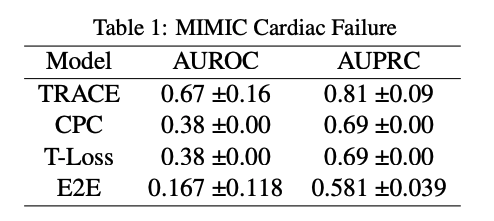

In [11]:
Image('cardiac_failure_results.png')

From our results it is clear that TRACE outperforms the other models. It has a better AUROC and AUPRC score compared to the other models we chose as baselines. This proves our claim/hypothesis that TRACE would outperform all the baseline models

These were the results from the original paper:

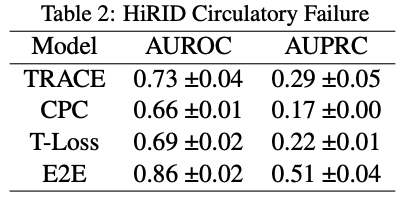

In [12]:
Image('circulatory_failure_results.png')

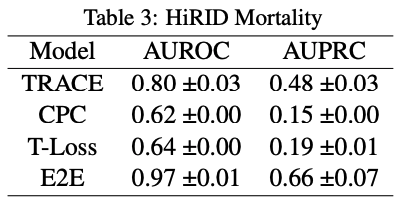

In [13]:
Image('mortality_results.png')

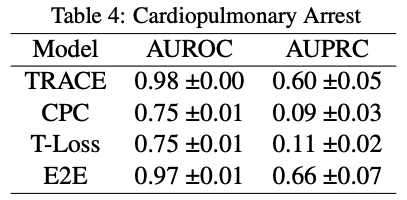

In [14]:
Image('cardiopulmonary_arrest_results.png')

Comparing to our own results, it is interesting to
note that AUPRC score does not go above 0.5 for
any of the models in the original paper. This
means that the model performs worse than random
chance at making positive predictions. Comparing
that to the performance on the MIMIC dataset, our
AUPRC scores overall are much higher in
comparison.


On the other hand, AUROC scores across the
board are much lower for all models. There is an
especially stark difference between E2E for the
MIMIC and HiRID data-sets. This means that our
models in comparison to the original paper’s
models are less likely to make predictions
accurately, this especially being true for E2E.


The original paper shows a significant difference
in performance metrics for TRACE compared to
the other models, and that trend is even more
apparent in our own experiment. Given the results,
it is fair to say that our experiment supports the
original paper’s hypothesis that TRACE or patient
representation learning is useful as a model and
can be generalized to any labels that could be
created for data.

# References

Jean-Yves Franceschi, Aymeric Dieuleveut, and Martin
Jaggi. 2020. Unsupervised scalable representation learn-
ing for multivariate time series. In 33rd Conference on
Neural Information Processing Systems.

George B. Moody and Roger G. Mark. 1996. A database
to support development and evaluation of intelligent
intensive care monitoring. In Computers in Cardiology
23:657-660.

Aaron van den Oord, Yazhe Li, and Oriol Vinyals. 2019.
Representation learning with contrastive predictive cod-
ing. In Preprint.

Sana Tonekaboni, Danny Eytan, and Anna Goldenberg. 2021. Unsupervised representation learning for time
series with temporal neighborhood coding. In Interna-
tional Conference on Learning Representations.

Addison Weatherhead, Robert Greer, Michael-Alice
Moga, Mjaye Mazwi, Danny Eytan, Anna Goldenberg,
and Sana Tonekaboni. 2022. Learning unsupervised
representations for icu timeseries. In Proceedings of
the Conference on Health, Inference, and Learning, vol-
ume 174 of Proceedings of Machine Learning Research,
pages 152–168. PMLR.